In [1]:
from itertools import combinations, product

from functools import partial
from multiprocessing import Pool, cpu_count

from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import expon

from neurodsp.spectral import compute_spectrum
from neurodsp.sim import sim_oscillation

from fooof import FOOOF

from timescales.sim import sim_spikes_synaptic
from timescales.fit import fit_psd, convert_knee_val

In [2]:
def fit_grid_psd(sig, fs, grid, max_n_params=None, return_fm=False, n_jobs=-1, chunksize=1):
    
    # Create an array of param grid indices
    param_inds = np.array(list(product(*[list(range(len(i))) for i in list(grid.values())])))
    
    if max_n_params is not None and max_n_params < len(param_inds):
        sub_inds = np.random.choice(np.arange(len(param_inds)), max_n_params, replace=False)
        param_inds = param_inds[sub_inds]
        
    # Fit grid
    n_jobs = cpu_count() if n_jobs == -1 else n_jobs
    
    with Pool(processes=n_jobs) as pool:
        
        mapping = pool.imap(partial(_fit_psd, sig=sig, fs=fs, grid=grid, return_fm=return_fm),
                            param_inds, chunksize=chunksize)

        params = list(tqdm(mapping, desc='Fitting Spectra', total=len(param_inds)))
        
    return params
            
    
def _fit_psd(index, sig=None, fs=None, grid=None, return_fm=False):
    """Parallel PSD wrapper."""

    init_params = ['peak_width_limits', 'max_n_peaks', 'peak_threshold']
    self_params = ['knee_freq_bounds', 'exp_bounds']
    spec_params = ['nperseg', 'noverlap']
    
    init_kwargs = {}
    self_kwargs = {}
    spec_kwargs = {}
    
    for (k, v), ind in zip(grid.items(), index):
    
        if k in init_params:
            init_kwargs[k] = v[ind]
        elif k in spec_params:
            spec_kwargs[k] = v[ind]
        elif k in self_params:
            self_kwargs[k] = v[ind]
        elif k == 'freq_range':
            f_range = tuple(v[ind])
    
    # Compute spectrum
    freqs, powers = compute_spectrum(sig, fs, f_range=f_range, **spec_kwargs)
    
    # Fit
    peak_width_limits = tuple(init_kwargs.pop('peak_width_limits'))
    
    fm = FOOOF(aperiodic_mode='knee', verbose=False, peak_width_limits=peak_width_limits,
               **init_kwargs)
    
    # Bounds for aperiodic fitting, as: ((offset_low_bound, knee_low_bound, exp_low_bound),
    #                                    (offset_high_bound, knee_high_bound, exp_high_bound))
    knee_low_bound, knee_high_bound = self_kwargs['knee_freq_bounds']
    exp_low_bound, exp_high_bound = self_kwargs['exp_bounds']
    
    fm._ap_bounds = ((-np.inf, knee_low_bound, exp_low_bound),
                     (np.inf, knee_high_bound,exp_high_bound))
    
    fm._ap_guess = (None, (knee_low_bound+knee_high_bound)/2, (exp_low_bound+exp_low_bound)/2)
    
    try:
        fm.fit(freqs, powers, freq_range=f_range)
        knee_freq = fm.get_params('aperiodic', 'knee')
        rsq = fm.r_squared_
    except:
        knee_freq = np.nan
        rsq = np.nan
        fm = np.nan
        
    if return_fm:
        return [index, knee_freq, rsq, fm]
    else:
        return [index, knee_freq, rsq]
    
    del fm
    
def subselect_params(grid, grid_indices, inds):
    
    params_sub = {}
    
    for k in grid.keys():
        params_sub[k] = []

    for inds in grid_indices[inds]:
        for ind, k in zip(inds, specparam_grid.keys()):
            params_sub[k].append(specparam_grid[k][ind])
    
    return params_sub

### Simulate

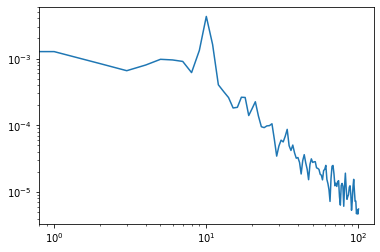

In [3]:
# Add oscillation
np.random.seed(0)

n_seconds = 10
fs = 1000
tau = 0.025
mu = 100
std = 100

isi = expon.rvs(size=int(n_seconds * fs))
isi -= isi.mean()
isi = isi * std + mu
isi = np.round_(isi).astype(int)

probs, _ = sim_spikes_synaptic(n_seconds, fs, tau, n_neurons=1, isi=isi, return_sum=False)

# Add oscillation
cos = sim_oscillation(n_seconds, fs, 10, phase='max')
cos -= cos.min()
cos /= cos.max()

sig = probs + (cos * .2)

f, p = compute_spectrum(sig, fs, f_range=(0, 100))
plt.loglog(f, p);

### Fit Grid

In [4]:
# 120,000 combinations
specparam_grid = {
    # Init kwargs
    'peak_width_limits': np.array(list(combinations(np.arange(1, 10, 2), 2))),
    'max_n_peaks': np.arange(1, 13, 3),
    'peak_threshold': np.arange(1, 5),
    # Self kwargs (post-init)
    'knee_freq_bounds': np.column_stack((np.arange(0, 100, 10), np.arange(0, 100, 10)+20)),
    'exp_bounds': np.column_stack((np.array([.01, 1, 2]), np.arange(2, 5))),
    # Compute spectra kwargs
    'nperseg': (np.linspace(.5, 1.5, 5) * fs).astype(int),
    'noverlap': np.arange(0, 10, 2)/10,
    # Fit kwargs
    'freq_range': np.array([[0, 100]])#np.column_stack((np.zeros(10), np.arange(10, 110, 10)))
}

In [5]:
params = fit_grid_psd(sig, fs, specparam_grid, max_n_params=int(1e4), return_fm=True, n_jobs=-1, chunksize=20)

Fitting Spectra:   0%|          | 0/10000 [00:00<?, ?it/s]

/tmp/ipykernel_15882/3639549581.py:21: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(params)


### Visualize Results

The most important parameter to tune is `knee_freq_bounds`. When this param is constrained to the ground truth range (i.e. 5-15 Hertz), most timescales are estimated within an appropriate range and the mean of the parameter grid approaches ground truth. R^2 alone can't differentiate between appropriate parameter sets. 

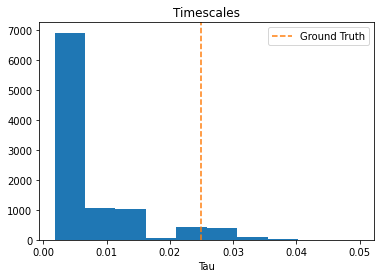

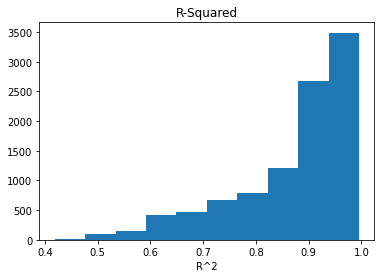

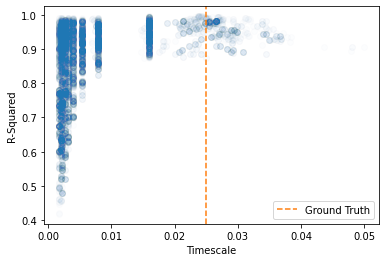

In [6]:
plt.figure(0)
knees = np.array([convert_knee_val(i) for i in params[:, 1]])
plt.hist(knees)
plt.axvline(tau, ls='--', color='C1', label='Ground Truth')
plt.title('Timescales')
plt.xlabel('Tau')
plt.legend();

plt.figure(1)
plt.hist(params[:, 2])
plt.title('R-Squared')
plt.xlabel('R^2')

plt.figure(2)
rsqs = params[:, 2]
plt.scatter(knees, rsqs, alpha=.01)
plt.xlabel('Timescale')
plt.ylabel('R-Squared')
plt.axvline(tau, color='C1', ls='--', label='Ground Truth')
plt.legend();

### Aperiodic R-Squared
Next, we look into a way to determined "good" vs "bad" fits, using something other than full model r-squared, which isn't descriminative enough. The proposed measure is the r^2 of the aperiodic component - this assumes the model that minimizes peak power (or the model with most baseline aperiodic power) is preferred. The 10 Hz knee is best captured when the knee is limited to 0-20 Hz. This may be quantified without a priori assumptions by maximizing the aperiodic r-squared.

In [7]:
r_squared_ap = np.zeros(len(params))
r_squared_ap[:] = np.nan

for ind, p in enumerate(params):
    r_val = np.corrcoef(p[3].power_spectrum, p[3]._ap_fit)
    r_squared_ap[ind] = r_val[0][1] ** 2

knee_param_inds = np.array([p[0][3] for p in params])

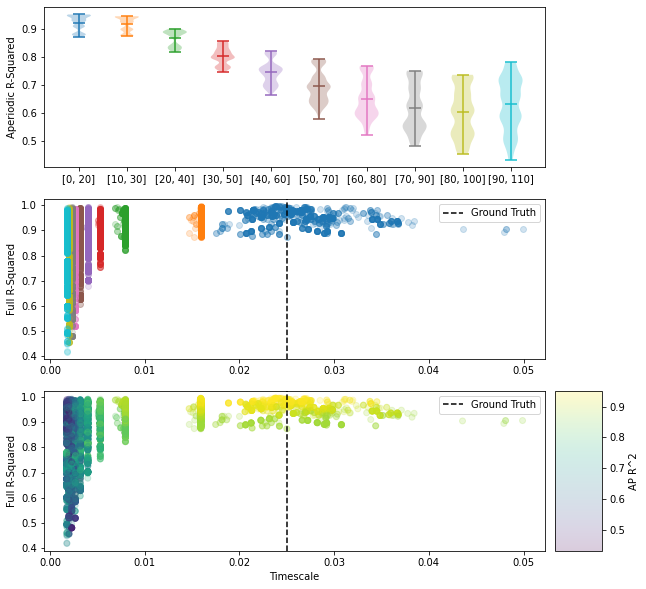

In [8]:
fig = plt.figure(figsize=(10, 10))

gs = fig.add_gridspec(nrows=3, ncols=10)

ax0 = fig.add_subplot(gs[0, :9])
ax1 = fig.add_subplot(gs[1, :9])
ax2 = fig.add_subplot(gs[2, :9])
ax3 = fig.add_subplot(gs[2, 9:])


for i in np.unique(knee_param_inds):
    ax0.violinplot(r_squared_ap[np.where(knee_param_inds == i)[0]], positions=[i+1], showmeans=True)
    
ax0.set_xticks(np.arange(1, len(specparam_grid['knee_freq_bounds'])+1))
ax0.set_xticklabels([str(i) for i in specparam_grid['knee_freq_bounds'].tolist()])
           
ax0.set_ylabel('Aperiodic R-Squared')


colors = ['C'+str(i) for i in range(len(specparam_grid['knee_freq_bounds']))]

for i, c in zip(np.unique(knee_param_inds), colors):
    inds = np.where(knee_param_inds == i)[0]
    ax1.scatter(knees[inds], rsqs[inds], alpha=.2, c=c)
    
ax1.set_ylabel('Full R-Squared')
ax1.axvline(tau, color='k', ls='--', label='Ground Truth')
ax1.legend()


sc = ax2.scatter(knees, rsqs, alpha=.2, c=r_squared_ap)
cbar = plt.colorbar(sc, ax=ax2, use_gridspec=True, cax=ax3)
ax3.set_ylabel('AP R^2')

ax2.set_xlabel('Timescale')
ax2.set_ylabel('Full R-Squared')
ax2.axvline(tau, color='k', ls='--', label='Ground Truth')
ax2.legend();

### Restrict the Grid

Next, the parameter grid is restricted by setting the knee range to (0, 20) Hz, as determined aboved. This reduces the grid size to 12,000 combinations, from 120,000. The mean of the timescale distribution, from all other parameter combinations, approaches ground truth. This may offer an alternative to Zeraati 2022, assuming sampling a variety of spectral and spectral fitting parameters removes finitie duration bias.

In [9]:
# Restrict grid based on knee range
# This reduces the grid to 12,000 combinations (from 120,000)
r2_per_knee_band = np.array([r_squared_ap[np.where(knee_param_inds == i)[0]].mean()
                              for i in np.unique(knee_param_inds)])

knee_freq_bounds = np.array([specparam_grid['knee_freq_bounds'][r2_per_knee_band.argmax()]])

specparam_grid_restrict = {
    # Init kwargs
    'peak_width_limits': np.array(list(combinations(np.arange(1, 10, 2), 2))),
    'max_n_peaks': np.arange(1, 13, 3),
    'peak_threshold': np.arange(1, 5),
    # Self kwargs (post-init)
    'knee_freq_bounds': knee_freq_bounds,
    'exp_bounds': np.column_stack((np.array([.01, 1, 2]), np.arange(2, 5))),
    # Compute spectra kwargs
    'nperseg': (np.linspace(.5, 1.5, 5) * fs).astype(int),
    'noverlap': np.arange(0, 10, 2)/10,
    # Fit kwargs
    'freq_range': np.array([[0, 100]]) #np.column_stack((np.zeros(10), np.arange(10, 110, 10)))
}

In [10]:
params = fit_grid_psd(sig, fs, specparam_grid_restrict, return_fm=True, n_jobs=-1, chunksize=20)

Fitting Spectra:   0%|          | 0/12000 [00:00<?, ?it/s]

/tmp/ipykernel_15882/3639549581.py:21: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(params)


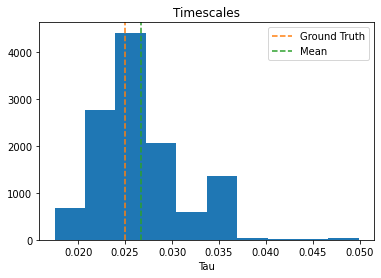

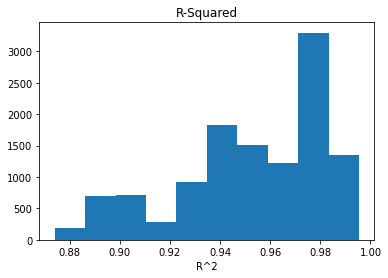

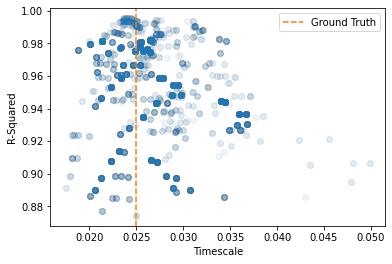

In [14]:
knees = np.array([convert_knee_val(i) for i in params[:, 1]])
rsqs = params[:, 2]

plt.figure(0)
plt.hist(knees)
plt.axvline(tau, ls='--', color='C1', label='Ground Truth')
plt.axvline(np.mean(knees), ls='--', color='C2', label='Mean')
plt.title('Timescales')
plt.xlabel('Tau')
plt.legend();

plt.figure(1)
plt.hist(params[:, 2])
plt.title('R-Squared')
plt.xlabel('R^2')

plt.figure(2)
plt.scatter(knees, rsqs, alpha=.01)
plt.xlabel('Timescale')
plt.ylabel('R-Squared')
plt.axvline(tau, color='C1', ls='--', label='Ground Truth')
plt.legend();